In [42]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import utils.evaluation
import utils.metrics

from skimage.transform import rescale, resize
from skimage.color import rgb2gray,rgb2lab

In [43]:
config_vars = {}

## Set path variables

Here you need to change the pathway to where your images lie. The image name of the cellprofiler image, is expected to be the same as the name of the ground truth annotation. 

You will have 3 folders for this:

    1. One folder for the ground truth annotations
    2. One folder where you store the cellprofiler predictions
    3. One folder where the label images, created from the cellprofiler prediction, will be stored 
    
The cellprofiler image is expected to be of the same size as the ground truth annotation (1104x1104)

In [44]:
# Change to the image name
image_name = 'MFGTMPcx7_170702090001_K22f14d0.png'




# Change this variable to where the ground truth images (the true annotations) are stored.
config_vars["raw_annotations_dir"] ='/home/malou/Projects/0_MasterProject/2_data/0_Aits_images/Annotations/raw_annotations/'
# Change this to a new folder where you will store the labels created in this script
config_vars["labels_out_dir"] = '/home/malou/Projects/0_MasterProject/0_src/python/evaluate_single_images/segmentated_images/'
# Change path to where you store the CellProfiler prediction
full_path_loading_img = '/home/malou/Projects/0_MasterProject/0_src/python/evaluate_single_images/cellprofiler_image/' + image_name


full_path_saving_img = config_vars["labels_out_dir"] + image_name


In [45]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

## Loading Cellprofiler prediction, and creating labels

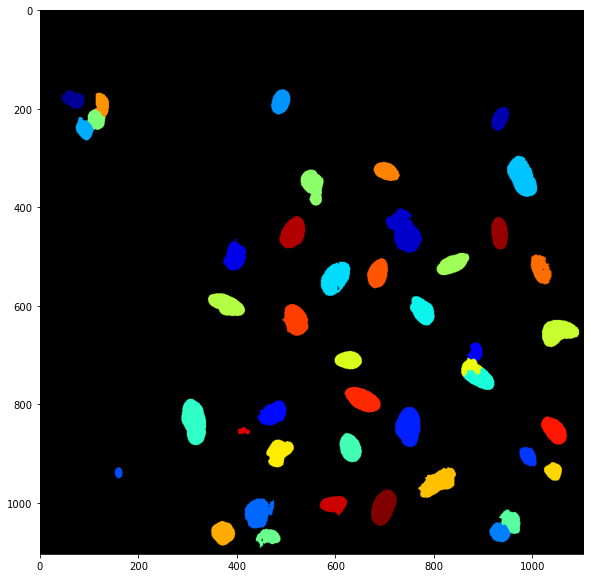

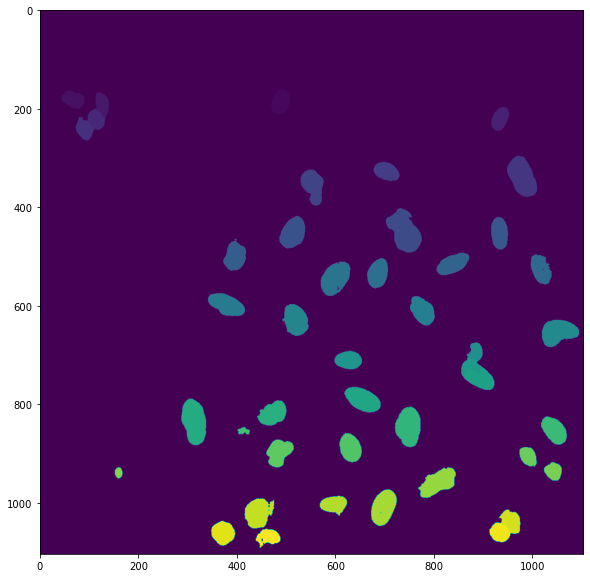

<ipython-input-46-2e13c4bb69e8>:17: UserWarning: /home/malou/Projects/0_MasterProject/0_src/python/evaluate_single_images/segmentated_images/MFGTMPcx7_170702090001_K22f14d0.png is a low contrast image
  skimage.io.imsave(full_path_saving_img, annot)
Lossy conversion from int64 to uint8. Range [0, 44]. Convert image to uint8 prior to saving to suppress this warning.


In [46]:
im = skimage.io.imread(full_path_loading_img)

plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()

im = rgb2lab(im)
im2 = im[:,:,0]

annot = skimage.morphology.label(im2)

plt.figure(figsize=(10,10))
plt.imshow(annot)
plt.show()


skimage.io.imsave(full_path_saving_img, annot)

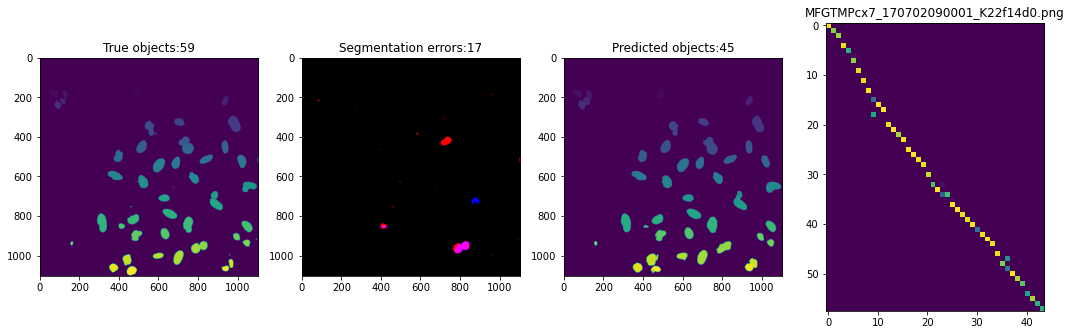

In [47]:

#all_images = data_partitions[partition]

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

#for image_name in all_images:
# Load ground truth data
img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
ground_truth = skimage.io.imread(img_filename)
#ground_truth = ground_truth.squeeze()
if len(ground_truth.shape) == 3:
    ground_truth = rgb2lab(ground_truth)
    ground_truth = ground_truth[:,:,0]

ground_truth = skimage.morphology.label(ground_truth)

# Transform to label matrix
#ground_truth = skimage.morphology.label(ground_truth)

# Load predictions

pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
prediction = skimage.io.imread(pred_filename)

# Apply object dilation
#if config_vars["object_dilation"] > 0:
#struct = skimage.morphology.square(config_vars["object_dilation"])
#prediction = skimage.morphology.dilation(prediction, struct)
#elif config_vars["object_dilation"] < 0:
#    struct = skimage.morphology.square(-config_vars["object_dilation"])
#    prediction = skimage.morphology.erosion(prediction, struct)

####################################################################################    
#### Testing prediction with no small objects on annot and prediction #####
#ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=100) 
#prediction = skimage.morphology.remove_small_objects(prediction, min_size=50)
#####################################################################################

# Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]

# Compute evaluation metrics
results = utils.evaluation.compute_af1_results(
    ground_truth, 
    prediction, 
    results, 
    image_name
)

false_negatives = utils.evaluation.get_false_negatives(
    ground_truth, 
    prediction, 
    false_negatives, 
    image_name
)

false_positives = utils.evaluation.get_false_positives(
    ground_truth, 
    prediction, 
    false_positives, 
    image_name
)

splits_merges = utils.evaluation.get_splits_and_merges(
    ground_truth, 
    prediction, 
    splits_merges, 
    image_name
)

# Display an example image
#if image_name == all_images[0]:
show(ground_truth, prediction, image_name=image_name)

In [48]:
# Display accuracy results

average_performance = results.groupby("Threshold").mean().reset_index()

R = results.groupby("Image").mean().reset_index()
#g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)

,Image,Threshold,F1,Jaccard
0,MFGTMPcx7_170702090001_K22f14d0.png,0.725,0.603922,0.816458


In [49]:
# Plot accuracy results

#sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

,Threshold,F1,Jaccard
0,0.50,0.803922,0.816458
1,0.55,0.803922,0.816458
2,0.60,0.764706,0.816458
3,0.65,0.705882,0.816458
4,0.70,0.666667,0.816458
5,0.75,0.647059,0.816458
6,0.80,0.588235,0.816458
7,0.85,0.509804,0.816458
8,0.90,0.490196,0.816458
9,0.95,0.058824,0.816458


In [50]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.6039215686215302
Jaccard index: 0.8164579017435905


In [51]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

Area
Tiny nuclei      12
Small nuclei      5
Normal nuclei     5
Large nuclei      2
Name: False_Negative, dtype: int64

In [52]:
falseP = false_positives[false_positives["False_Positive"] == 1]

FP_Area_chart = falseP.groupby(
    pd.cut(
        falseP["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Positive"].sum()

total_Positives = len(false_positives)
print(FP_Area_chart)

print("FDR Tiny:", "%.4f" % (FP_Area_chart["Tiny nuclei"]/total_Positives))

print("FDR Small:", "%.4f" % (FP_Area_chart["Small nuclei"]/total_Positives))

print("FDR Normal:", "%.4f" % (FP_Area_chart["Normal nuclei"]/total_Positives))

print("FDR Large:", "%.4f" % (FP_Area_chart["Large nuclei"]/total_Positives))


Area
Tiny nuclei      NaN
Small nuclei     3.0
Normal nuclei    5.0
Large nuclei     2.0
Name: False_Positive, dtype: float64
FDR Tiny: nan
FDR Small: 0.0682
FDR Normal: 0.1136
FDR Large: 0.0455


In [53]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 1
Merges: 2


In [54]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Extra objects (false postives): 10


In [55]:
thresh = 0.7


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 10
True positives: 34
Total objects: 44
False discovery rate: 0.22727272727272727
